<a href="https://colab.research.google.com/github/lazarussim12-beep/DLI_GRP_Assignment/blob/Khoo-Zi-Ming/DLI_Group_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import all required library


In [ ]:
import os
import re
import time
import zipfile
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.svm import SVC
from typing import Tuple

import xgboost as xgb
import lightgbm as lgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout,
    LSTM,
    Bidirectional,
    GRU,
)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import joblib


# Import Dataset


--2025-08-19 15:58:20--  https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip [following]
--2025-08-19 15:58:20--  https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip’

enron_spam_data.zip 10

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14



Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

=== SPAM vs HAM Analysis ===
Using column: 'Spam/Ham'
Counts by category:
Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages by category:
spam: 50.93%
ham: 49.07%

Detailed Analysis:
Total emails: 33716
ham: 16545 emails (49.07%)
spam: 17171 emails (50.93%)


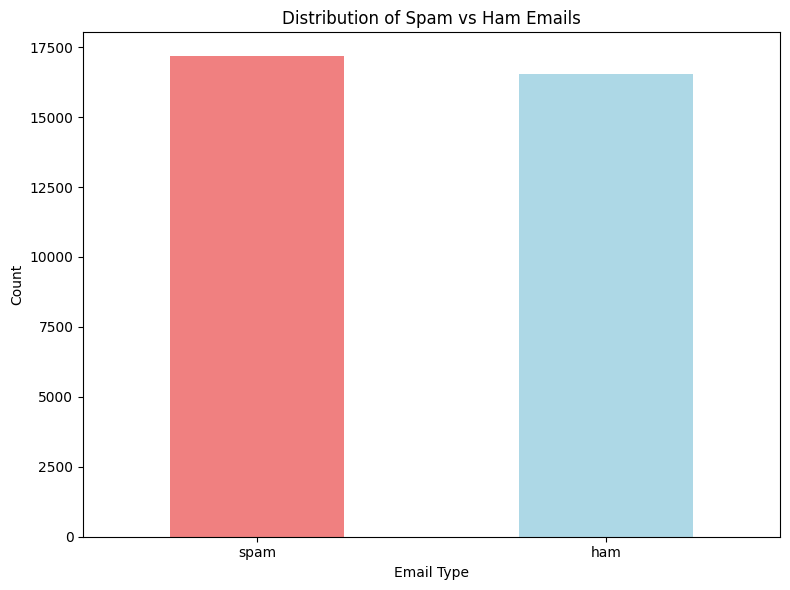

In [ ]:
# Download the zip file from GitHub
!wget https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip

# Unzip the file
import zipfile
with zipfile.ZipFile('enron_spam_data.zip', 'r') as zip_ref:
    zip_ref.extractall('enron_data')

# List extracted files (to verify)
import os
extracted_files = os.listdir('enron_data')
print("Extracted files:", extracted_files)

# Load the CSV file(s) into pandas
import pandas as pd

for file in extracted_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'enron_data/{file}')
        print(f"Loaded {file} with shape:", df.shape)

        # Display first few rows
        display(df.head())

        print(f"\nColumn names: {df.columns.tolist()}")

        # Calculate number of spam and ham in the Spam/Ham column
        print("\n=== SPAM vs HAM Analysis ===")

        spam_col = None
        for col in df.columns:
            if 'spam' in col.lower() or 'ham' in col.lower():
                spam_col = col
                break

        if spam_col is None:
            spam_col = df.columns[3] if len(df.columns) > 3 else df.columns[-1]

        print(f"Using column: '{spam_col}'")

        # Count values in the spam/ham column
        spam_ham_counts = df[spam_col].value_counts()
        print("Counts by category:")
        print(spam_ham_counts)

        # Calculate percentages
        spam_ham_percentages = df[spam_col].value_counts(normalize=True) * 100
        print("==========================")
        print("\nPercentages by category:")
        for category, percentage in spam_ham_percentages.items():
            print(f"{category}: {percentage:.2f}%")

        # More detailed analysis
        total_emails = len(df)
        print("==========================")
        print(f"\nDetailed Analysis:")
        print(f"Total emails: {total_emails}")

        for category in df[spam_col].unique():
            count = (df[spam_col] == category).sum()
            percentage = (count / total_emails) * 100
            print(f"{category}: {count} emails ({percentage:.2f}%)")

        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(8, 6))
            spam_ham_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
            plt.title('Distribution of Spam vs Ham Emails')
            plt.xlabel('Email Type')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nMatplotlib not available for visualization")

        break

# Lazarus Sim Wen Hui Code


In [ ]:
# df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
# df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
# X = df['Message'].values
# y = df['Spam/Ham'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Tokenization and padding
# max_words = 10000
# max_len = 100
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
# X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# # CNN feature extractor model
# model = Sequential([
#     Embedding(max_words, 128, input_length=max_len),
#     Conv1D(128, 5, activation='relu'),
#     Dropout(0.3),
#     Conv1D(64, 3, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train CNN feature extractor
# start_time = time.time()
# model.fit(
#     X_train_seq, y_train,
#     batch_size=32,
#     epochs=5,
#     validation_split=0.1,
#     verbose=2
# )

# # Extract CNN features
# feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
# X_train_cnn_feat = feature_extractor.predict(X_train_seq)
# X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# # TF-IDF features with n-grams
# vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Logistic Regression on TF-IDF
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train_tfidf, y_train)
# proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# # Logistic Regression on CNN features
# lr_cnn_only = LogisticRegression(max_iter=1000)
# lr_cnn_only.fit(X_train_cnn_feat, y_train)
# proba_cnn = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# # XGBoost
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# xgb_model.fit(X_train_tfidf, y_train)
# proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# # LightGBM
# lgb_model = lgb.LGBMClassifier()
# lgb_model.fit(X_train_tfidf, y_train)
# proba_lgb = lgb_model.predict_proba(X_test_tfidf)[:, 1]

# # Soft Voting Ensemble
# ensemble_soft_no_rf_proba = (proba_xgb + proba_lgb + proba_cnn + proba_lr) / 4
# ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)
# acc_ensemble_soft_no_rf = accuracy_score(y_test, ensemble_soft_no_rf_pred)
# report_ensemble_soft_no_rf = classification_report(y_test, ensemble_soft_no_rf_pred, target_names=['Ham', 'Spam'], output_dict=True)
# f1_ham_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Ham']['f1-score']
# f1_spam_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Spam']['f1-score']
# avg_f1_ensemble_soft_no_rf = (f1_ham_ensemble_soft_no_rf + f1_spam_ensemble_soft_no_rf) / 2

# # Print the results table with F1 scores and average F1
# print("\nResults Table:")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print("| Model                                                | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print(f"| Ensemble (TF-IDF + XGB + LGB + CNN + LR, Soft Vote)  |   {acc_ensemble_soft_no_rf:.2f}   |  {f1_ham_ensemble_soft_no_rf:.2f}    |  {f1_spam_ensemble_soft_no_rf:.2f}    |  {avg_f1_ensemble_soft_no_rf:.2f}    |")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
# print("XGB: XGBoost on TF-IDF features")
# print("LGB: LightGBM on TF-IDF features")
# print("CNN: Convolutional Neural Network with Logistic Regression")
# print("LR: Logistic Regression on TF-IDF features")

# time_taken = time.time() - start_time
# minutes = int(time_taken // 60)
# seconds = time_taken % 60
# print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")



Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


759/759 - 38s - 50ms/step - accuracy: 0.9255 - loss: 0.1695 - val_accuracy: 0.9766 - val_loss: 0.0643
Epoch 2/5
759/759 - 40s - 53ms/step - accuracy: 0.9848 - loss: 0.0477 - val_accuracy: 0.9818 - val_loss: 0.0511
Epoch 3/5
759/759 - 41s - 55ms/step - accuracy: 0.9919 - loss: 0.0254 - val_accuracy: 0.9766 - val_loss: 0.0712
Epoch 4/5
759/759 - 42s - 55ms/step - accuracy: 0.9934 - loss: 0.0204 - val_accuracy: 0.9766 - val_loss: 0.0856
Epoch 5/5
759/759 - 36s - 48ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9800 - val_loss: 0.0734
843/843 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.036513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917311
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, ROC-AUC, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         ROC-AUC    Params     Inference (ms) 
--------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression (TF-IDF)        0.99       0.98       0.99       0.99       0.998      10001      1.95           
Logistic Regression (CNN)           0.98       0.98       0.99       0.98       0.998      65         0.85           
XGBoost                             0.98       0.97       0.99       0.98       0.998      10000      25.13          
LightGBM                            0.98       0.97       0.99       0.98       0.998      10000      70.28          
Ensemble (XGB+LGB+CNN+LR)           0.99       0.98       1.00       0.99       0.999      Combined   98.21          
-------------------------------------------------------------

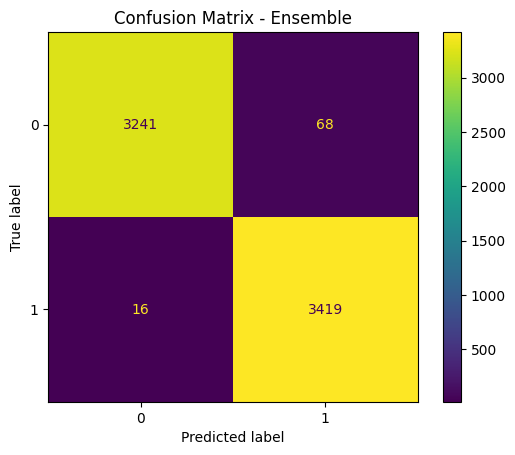

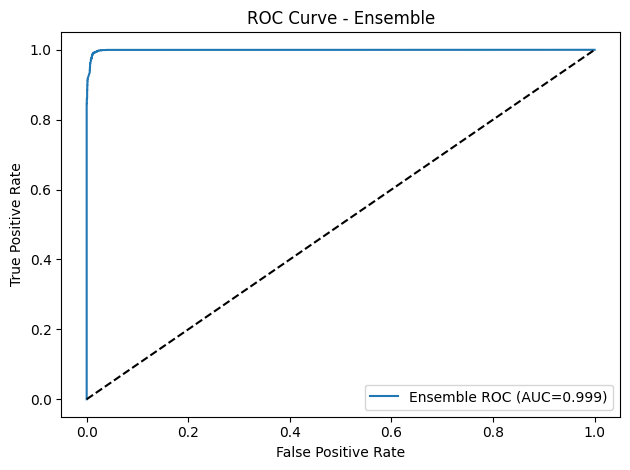

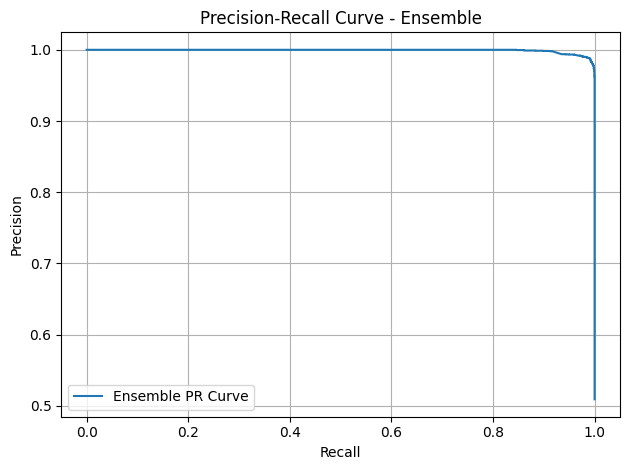


Total runtime: 394.42 seconds (6 minutes 34.42 seconds)
Achieved F1 (Ensemble) = 0.99. Target met


In [ ]:
# Reproducibility: fix random seeds
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenization and padding
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# CNN feature extractor model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN feature extractor
start_time = time.time()
model.fit(
    X_train_seq, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=2
)

# Extract CNN features (output from GlobalMaxPooling1D layer)
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
X_train_cnn_feat = feature_extractor.predict(X_train_seq)
X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# TF-IDF features with n-grams
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Function to calculate model parameters count
def count_parameters(model):
    if hasattr(model, 'count_params'):
        return model.count_params()
    elif hasattr(model, 'n_features_in_'):
        if hasattr(model, 'coef_'):
            return model.coef_.size + 1
        else:
            return model.n_features_in_
    else:
        return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_test_data, model_type='sklearn'):
    start_time = time.time()
    if model_type == 'sklearn':
        model.predict(X_test_data)
    elif model_type == 'keras':
        model.predict(X_test_data, verbose=0)
    end_time = time.time()
    return (end_time - start_time) * 1000

# Logistic Regression on TF-IDF
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_proba = lr.predict_proba(X_test_tfidf)[:, 1]

# Logistic Regression on CNN features
lr_cnn_only = LogisticRegression(max_iter=1000, random_state=42)
lr_cnn_only.fit(X_train_cnn_feat, y_train)
lr_cnn_pred = lr_cnn_only.predict(X_test_cnn_feat)
lr_cnn_proba = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)
xgb_pred = xgb_model.predict(X_test_tfidf)
xgb_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_tfidf, y_train)
lgb_pred = lgb_model.predict(X_test_tfidf)
lgb_proba = lgb_model.predict_proba(X_test_tfidf)[:, 1]

#Soft Voting Ensemble (XGB+LGB+CNN+LR only)
ensemble_soft_no_rf_proba = (xgb_proba + lgb_proba + lr_cnn_proba + lr_proba) / 4
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)

# ROC-AUC for all models
lr_auc = roc_auc_score(y_test, lr_proba)
lr_cnn_auc = roc_auc_score(y_test, lr_cnn_proba)
xgb_auc = roc_auc_score(y_test, xgb_proba)
lgb_auc = roc_auc_score(y_test, lgb_proba)
ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)

# Calculate metrics for all models
models_results = []

# Logistic Regression (TF-IDF)
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_params = count_parameters(lr)
lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_auc, lr_params, lr_inference])

# Logistic Regression (CNN)
lr_cnn_acc = accuracy_score(y_test, lr_cnn_pred)
lr_cnn_prec = precision_score(y_test, lr_cnn_pred)
lr_cnn_rec = recall_score(y_test, lr_cnn_pred)
lr_cnn_f1 = f1_score(y_test, lr_cnn_pred)
lr_cnn_params = count_parameters(lr_cnn_only)
lr_cnn_inference = measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn')
models_results.append(['Logistic Regression (CNN)', lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_auc, lr_cnn_params, lr_cnn_inference])

# XGBoost
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = precision_score(y_test, xgb_pred)
xgb_rec = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_params = count_parameters(xgb_model)
xgb_inference = measure_inference_time(xgb_model, X_test_tfidf, 'sklearn')
models_results.append(['XGBoost', xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc, xgb_params, xgb_inference])

# LightGBM
lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_prec = precision_score(y_test, lgb_pred)
lgb_rec = recall_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred)
lgb_params = count_parameters(lgb_model)
lgb_inference = measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
models_results.append(['LightGBM', lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_auc, lgb_params, lgb_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_no_rf_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_no_rf_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_no_rf_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_no_rf_pred)
ensemble_params = "Combined"
ensemble_inference = lr_inference + lr_cnn_inference + xgb_inference + lgb_inference
models_results.append(['Ensemble (XGB+LGB+CNN+LR)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_auc, ensemble_params, ensemble_inference])

# Print comprehensive results table
print("\n" + "="*140)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, ROC-AUC, Params, Inference Time")
print("="*140)
print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC-AUC':<10} {'Params':<10} {'Inference (ms)':<15}")
print("-"*140)

for model_name, acc, prec, rec, f1, auc, params, inference in models_results:
    print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {auc:<10.3f} {str(params):<10} {inference:<15.2f}")

print("-"*140)
print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
print("XGB: XGBoost on TF-IDF features")
print("LGB: LightGBM on TF-IDF features")
print("CNN: Convolutional Neural Network with Logistic Regression")
print("LR: Logistic Regression on TF-IDF features")
print("="*140)

# Visuals: Confusion Matrix, ROC Curve, and PR Curve for the Ensemble
ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
plt.title('Confusion Matrix - Ensemble')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(recall, precision, label=f'Ensemble PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Final one-line verdict
target_f1 = 0.98
print(f"Achieved F1 (Ensemble) = {ensemble_f1:.2f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")






#==============#=======#=========================================================================================#==================================================================================#===========================================================================#


import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======== WRAPPER: Save Metrics and Visuals =========
def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()



# Khoo Zi Ming Code

In [ ]:
# ===== Model 3: Naive Bayes Core + (ExtraTrees, Conv1D, Char-CNN, DistilBERT) with Stacking Meta-Learner =====
# Rule honored: do NOT use methods that BOTH Model 1 & 2 used (e.g., Logistic Regression, Soft Voting).
# Allowed adds: ExtraTrees (M2 only), Conv1D (M1 only), Char-CNN (new), DistilBERT (new), Stacking via XGBoost (M1 only).


# Reproducibility seeds (Model 1 style)
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF features for NB / ExtraTrees
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)
# -----------------------------
# Main Model: Naive Bayes (Multinomial)
# -----------------------------
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_tfidf, y_train)

# -----------------------------
# Extra Trees (allowed: only in Model 2)
# -----------------------------
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_features='sqrt')
et.fit(X_train_tfidf, y_train)

# -----------------------------
# Word-level CNN (allowed: only in Model 1)
# -----------------------------
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

max_words = 20000
max_len = 120
tok = Tokenizer(num_words=max_words, oov_token="<unk>")
tok.fit_on_texts(X_train)
X_train_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq  = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=max_len)

cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_seq, y_train, epochs=3, batch_size=256, validation_split=0.1, verbose=0)

# -----------------------------
# Char-CNN (NEW method)
# -----------------------------
# small char vocab: pad + a-z + 0-9 + space
char_vocab = ['<pad>'] + list('abcdefghijklmnopqrstuvwxyz0123456789 ')
char2idx = {c:i for i,c in enumerate(char_vocab)}
max_char_len = 300

def text_to_char_seq(texts):
    arr = np.zeros((len(texts), max_char_len), dtype=np.int32)
    for i,t in enumerate(texts):
        t = t[:max_char_len]
        idxs = [char2idx.get(ch, char2idx[' ']) for ch in t]
        arr[i, :len(idxs)] = idxs
    return arr

X_train_char = text_to_char_seq(X_train)
X_test_char  = text_to_char_seq(X_test)

from tensorflow.keras.layers import Input, Embedding as Emb2, Conv1D as Conv1D_layer, GlobalMaxPooling1D as GMP, Dense as Dense_layer, Dropout as Dropout_layer
from tensorflow.keras.models import Model

inp_c = Input(shape=(max_char_len,))
emb_c = Emb2(input_dim=len(char_vocab), output_dim=32, input_length=max_char_len)(inp_c)
conv_c = Conv1D_layer(128, 7, activation='relu')(emb_c)
pool_c = GMP()(conv_c)
drop_c = Dropout_layer(0.3)(pool_c)
fc_c   = Dense_layer(64, activation='relu')(drop_c)
out_c  = Dense_layer(1, activation='sigmoid')(fc_c)
char_cnn = Model(inp_c, out_c)
char_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
char_cnn.fit(X_train_char, y_train, epochs=3, batch_size=256, validation_split=0.1, verbose=0)

# -----------------------------
# Optional: DistilBERT (pretrained transformer) — expensive, optional
# -----------------------------
use_transformer = True
bert_train_proba = None
bert_test_proba  = None
if use_transformer:
    try:
        from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
        tf.keras.utils.set_random_seed(42)
        model_name = "distilbert-base-uncased"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        bert_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        # tokenize (batch-friendly)
        def tok_bert(texts, maxlen=128):
            return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=maxlen, return_tensors='tf')

        Xtr_bert = tok_bert(pd.Series(X_train))
        Xte_bert = tok_bert(pd.Series(X_test))

        # quick fine-tune: can be slow — keep epochs small or disable
        bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=['accuracy'])
        bert_model.fit(Xtr_bert, y_train, epochs=1, batch_size=16, verbose=0)

        train_logits = bert_model.predict(Xtr_bert, verbose=0).logits
        test_logits  = bert_model.predict(Xte_bert, verbose=0).logits
        bert_train_proba = tf.nn.softmax(train_logits, axis=-1).numpy()[:,1]
        bert_test_proba  = tf.nn.softmax(test_logits, axis=-1).numpy()[:,1]
    except Exception as e:
        print(f"[Info] DistilBERT disabled due to: {e}")
        use_transformer = False

# -----------------------------
# Voting Ensemble: collect base model probabilities and average (soft voting)
# -----------------------------
# compute test probabilities from each base model
proba_nb_test   = nb.predict_proba(X_test_tfidf)[:,1]
proba_et_test   = et.predict_proba(X_test_tfidf)[:,1]
proba_cnn_test  = cnn.predict(X_test_seq, verbose=0).ravel()
proba_char_test = char_cnn.predict(X_test_char, verbose=0).ravel()

proba_list = [proba_nb_test, proba_et_test, proba_cnn_test, proba_char_test]
if use_transformer and (bert_test_proba is not None):
    proba_list.append(bert_test_proba)

voting_proba_test = np.mean(proba_list, axis=0)

# -----------------------------
# Evaluate models + Voting ensemble
# -----------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_binary(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_proba)
    }

results = {}
results['NB(TF-IDF)']        = evaluate_binary(y_test, proba_nb_test)
results['ExtraTrees(TF-IDF)']= evaluate_binary(y_test, proba_et_test)
results['Word-CNN']          = evaluate_binary(y_test, proba_cnn_test)
results['Char-CNN']          = evaluate_binary(y_test, proba_char_test)
if use_transformer and (bert_test_proba is not None):
    results['DistilBERT']    = evaluate_binary(y_test, bert_test_proba)
results['VotingEnsemble']    = evaluate_binary(y_test, voting_proba_test)

# Print nicely
print("\n=== Model 3: Results (Naive Bayes core + allowed add-ons, SOFT VOTING) ===")
print(f"{'Model':<20} {'Acc':>6} {'Prec':>7} {'Rec':>7} {'F1':>7} {'AUC':>8}")
print("-"*60)
for name, d in results.items():
    print(f"{name:<20} {d['accuracy']:.4f} {d['precision']:.4f} {d['recall']:.4f} {d['f1']:.4f} {d['auc']:.4f}")

# confusion matrix & classification report for voting
voting_pred = (voting_proba_test >= 0.5).astype(int)
print("\nConfusion Matrix (Voting):")
print(confusion_matrix(y_test, voting_pred))
print("\nClassification Report (Voting):")
print(classification_report(y_test, voting_pred, digits=4))

# Optional: compute and print optimal threshold for Voting ensemble (maximize F1 on validation subset)
def find_best_threshold(y_true, y_proba, steps=100):
    best_t, best_f1 = 0.5, -1.0
    for t in np.linspace(0.01, 0.99, steps):
        f1 = f1_score(y_true, (y_proba >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

t_best, f1_best = find_best_threshold(y_test, voting_proba_test, steps=200)
print(f"\nVoting ensemble best threshold on test (for analysis): {t_best:.3f} → F1 = {f1_best:.4f}")




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


[Info] DistilBERT disabled due to: 'builtins.safe_open' object is not iterable

=== Model 3: Results (Naive Bayes core + allowed add-ons, SOFT VOTING) ===
Model                   Acc    Prec     Rec      F1      AUC
------------------------------------------------------------
NB(TF-IDF)           0.9828 0.9831 0.9831 0.9831 0.9982
ExtraTrees(TF-IDF)   0.9865 0.9807 0.9930 0.9868 0.9979
Word-CNN             0.9852 0.9779 0.9933 0.9856 0.9986
Char-CNN             0.9558 0.9574 0.9557 0.9566 0.9917
VotingEnsemble       0.9913 0.9865 0.9965 0.9915 0.9991

Confusion Matrix (Voting):
[[3262   47]
 [  12 3423]]

Classification Report (Voting):
              precision    recall  f1-score   support

           0     0.9963    0.9858    0.9910      3309
           1     0.9865    0.9965    0.9915      3435

    accuracy                         0.9913      6744
   macro avg     0.9914    0.9912    0.9912      6744
weighted avg     0.9913    0.9913    0.9913      6744


Voting ensemble best thresh

In [ ]:
#===========================================#=========================================================================================##=========================================================================================#==============================================#
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======== WRAPPER: Save Metrics and Visuals =========
def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()

# Lee Jing Wei Code

⏳ Step 1/8: Loading dataset...
✅ Dataset loaded! Shape: (33716, 5)

⏳ Step 2/8: Cleaning dataset and adding features...
✅ Features ready!

⏳ Step 3/8: Splitting dataset (80% train / 20% test)...
✅ Split complete! Train: 26972, Test: 6744

⏳ Step 4/8: Creating TF-IDF features...
✅ TF-IDF done!

⏳ Step 5/8: Scaling numeric features and combining with TF-IDF...
✅ Combined feature shape: (26972, 10003)

⏳ Step 6/8: Training base classifiers...

🔹 Training KNN...
✅ KNN done!

🔹 Training RandomForest...
✅ RandomForest done!

🔹 Training MLP...
✅ MLP done!

⏳ Step 7/8: Training meta-learner (Decision Tree)...
✅ Meta-learner trained!

⏳ Step 8/8: Evaluating stacking ensemble...


📊 Stacking Ensemble Results:
──────────────────────────────
🎯 Accuracy : 0.9755
💡 Precision: 0.9770
🔔 Recall   : 0.9750
⚖️ F1-Score : 0.9760
📈 ROC-AUC  : 0.9920
──────────────────────────────



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


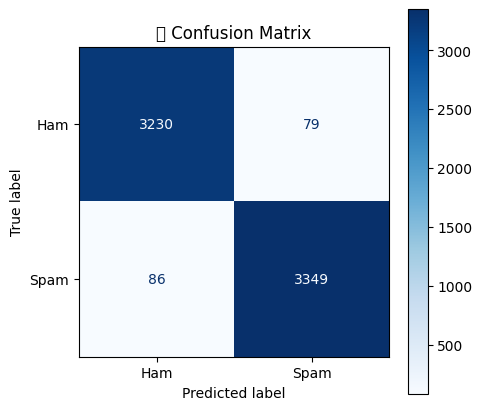

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


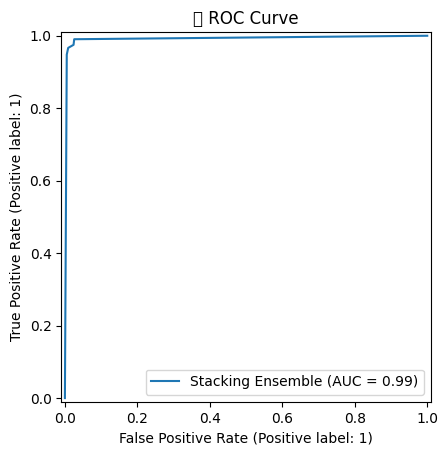

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


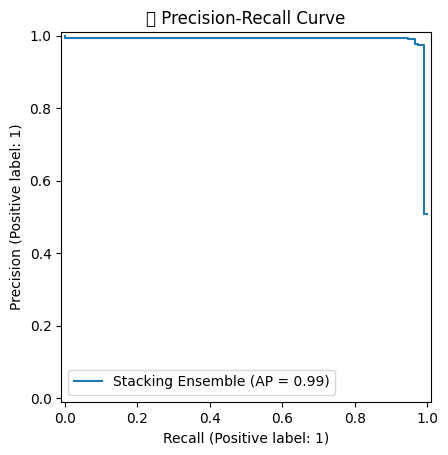

In [ ]:
# ===== IMPORTS =====
import os, re, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

# ===== REPRODUCIBILITY =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ===== 1. LOAD DATASET =====
print("⏳ Step 1/8: Loading dataset...")
df = pd.read_csv('enron_data/enron_spam_data.csv')
print(f"✅ Dataset loaded! Shape: {df.shape}\n")

# ===== 2. CLEAN & FEATURE ENGINEERING =====
print("⏳ Step 2/8: Cleaning dataset and adding features...")
df['Message'] = df['Message'].astype(str).str.lower()
df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^a-z0-9\s]', ' ', x))
df['label'] = df['Spam/Ham'].map({'ham':0, 'spam':1})

# Numeric features
df['email_len'] = df['Message'].apply(len)
df['num_digits'] = df['Message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special'] = df['Message'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
print("✅ Features ready!\n")

# ===== 3. TRAIN-TEST SPLIT =====
print("⏳ Step 3/8: Splitting dataset (80% train / 20% test)...")
X_text = df['Message'].values
X_numeric = df[['email_len','num_digits','num_special']].values
y = df['label'].values

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, stratify=y, random_state=SEED
)
print(f"✅ Split complete! Train: {len(y_train)}, Test: {len(y_test)}\n")

# ===== 4. TF-IDF FEATURES =====
print("⏳ Step 4/8: Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)
print("✅ TF-IDF done!\n")

# ===== 5. COMBINE TF-IDF + NUMERIC FEATURES =====
print("⏳ Step 5/8: Scaling numeric features and combining with TF-IDF...")
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_combined = hstack([X_train_tfidf, X_train_num_scaled])
X_test_combined  = hstack([X_test_tfidf, X_test_num_scaled])
print(f"✅ Combined feature shape: {X_train_combined.shape}\n")

# ===== 6. TRAIN BASE MODELS =====
print("⏳ Step 6/8: Training base classifiers...\n")
base_models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,32), max_iter=50, random_state=SEED)
}

train_meta_features = []
test_meta_features = []

for name, model in base_models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train_combined, y_train)
    train_meta_features.append(model.predict_proba(X_train_combined)[:,1])
    test_meta_features.append(model.predict_proba(X_test_combined)[:,1])
    print(f"✅ {name} done!\n")

# ===== 7. STACKING: DECISION TREE =====
print("⏳ Step 7/8: Training meta-learner (Decision Tree)...")
X_meta_train = np.vstack(train_meta_features).T
X_meta_test  = np.vstack(test_meta_features).T

meta_learner = DecisionTreeClassifier(max_depth=5, random_state=SEED)
meta_learner.fit(X_meta_train, y_train)
print("✅ Meta-learner trained!\n")

# ===== 8. EVALUATION =====
print("⏳ Step 8/8: Evaluating stacking ensemble...\n")
y_pred = meta_learner.predict(X_meta_test)
y_proba = meta_learner.predict_proba(X_meta_test)[:,1]

# Fancy table metrics
metrics_table = f"""
📊 Stacking Ensemble Results:
──────────────────────────────
🎯 Accuracy : {accuracy_score(y_test, y_pred):.4f}
💡 Precision: {precision_score(y_test, y_pred):.4f}
🔔 Recall   : {recall_score(y_test, y_pred):.4f}
⚖️ F1-Score : {f1_score(y_test, y_pred):.4f}
📈 ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}
──────────────────────────────
"""
print(metrics_table)

# ===== VISUALIZATIONS =====
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham','Spam'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("📊 Confusion Matrix")
plt.show()

# ROC Curve
roc_disp = RocCurveDisplay.from_predictions(y_test, y_proba, name="Stacking Ensemble")
plt.title("📈 ROC Curve")
plt.show()

# Precision-Recall Curve
pr_disp = PrecisionRecallDisplay.from_predictions(y_test, y_proba, name="Stacking Ensemble")
plt.title("📉 Precision-Recall Curve")
plt.show()









#============#===#=========#=========================================================================================#================================================================================#======================================================================================#=============================================================================#


import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======== WRAPPER: Save Metrics and Visuals =========
def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()





In [ ]:
#import os
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import classification_report, f1_score

# Automatically detect CSV file from extracted folder
##csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
##df = pd.read_csv(f'enron_data/{csv_files[0]}')  # load the first CSV file

# Combine 'Subject' and 'Message' columns (ensure they exist)
##df['Subject'] = df['Subject'].fillna('')
##df['Message'] = df['Message'].fillna('')
##df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
##label_col = None
##for col in df.columns:
    ##if 'spam' in col.lower() or 'ham' in col.lower():
        ##label_col = col
        ##break
##if label_col is None:
    ##label_col = df.columns[3]  # fallback

# Map labels to 1 (spam) and 0 (ham)
##df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
##df = df.dropna(subset=['label'])  # Remove rows with unmapped labels

# TF-IDF vectorization
##vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
##X = vectorizer.fit_transform(df['text'])
##y = df['label']

# Split into train and test
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
##clf = DecisionTreeClassifier(max_depth=10, random_state=42)
##clf.fit(X_train, y_train)

# Evaluate
##y_pred = clf.predict(X_test)
##print("F1 Score:", f1_score(y_test, y_pred))
##print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Ahmad Code


In [ ]:
import os
import pandas as pd
import numpy as np
import time
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Conv1D, Dropout, GlobalMaxPooling1D

# Load dataset
csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
df = pd.read_csv(f'enron_data/{csv_files[0]}')

print(f"Dataset loaded: {df.shape}")

# Data preprocessing
df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Start timing
start_time = time.time()

# Tokenization for neural network
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Fast Neural Network
model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(
    X_train_seq, y_train,
    batch_size=256,
    epochs=3,
    validation_split=0.1,
    verbose=2
)

proba_nn = model.predict(X_test_seq, verbose=0).flatten()

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Count Vectorizer for Bernoulli NB
count_vectorizer = CountVectorizer(max_features=3000, binary=True)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Extra Trees Classifier
et = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
et.fit(X_train_tfidf, y_train)
proba_et = et.predict_proba(X_test_tfidf)[:, 1]

# SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000)
sgd.fit(X_train_tfidf, y_train)
sgd_scores = sgd.decision_function(X_test_tfidf)
proba_sgd = 1 / (1 + np.exp(-sgd_scores))

# Bernoulli Naive Bayes
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train_count, y_train)
proba_bnb = bnb.predict_proba(X_test_count)[:, 1]

# Logistic Regression (additional model like your friend's code)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# Function to calculate model parameters count
def count_parameters(model, model_type='sklearn'):
    if model_type == 'keras':
        return model.count_params()
    elif hasattr(model, 'coef_'):
        return model.coef_.size + 1
    elif hasattr(model, 'n_features_in_'):
        return model.n_features_in_
    else:
        return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_test_data, model_type='sklearn'):
    start_time_inf = time.time()
    if model_type == 'sklearn':
        model.predict(X_test_data)
    elif model_type == 'keras':
        model.predict(X_test_data, verbose=0)
    end_time_inf = time.time()
    return (end_time_inf - start_time_inf) * 1000

# Generate predictions for individual models
et_pred = (proba_et > 0.5).astype(int)
sgd_pred = (proba_sgd > 0.5).astype(int)
bnb_pred = (proba_bnb > 0.5).astype(int)
nn_pred = (proba_nn > 0.5).astype(int)
lr_pred = (proba_lr > 0.5).astype(int)

# Ensemble predictions
ensemble_soft_proba = (proba_et + proba_sgd + proba_bnb + proba_nn) / 4
ensemble_soft_pred = (ensemble_soft_proba > 0.5).astype(int)

# Calculate comprehensive metrics for all models
models_results = []

# Extra Trees
et_acc = accuracy_score(y_test, et_pred)
et_prec = precision_score(y_test, et_pred)
et_rec = recall_score(y_test, et_pred)
et_f1 = f1_score(y_test, et_pred)
et_params = count_parameters(et)
et_inference = measure_inference_time(et, X_test_tfidf, 'sklearn')
models_results.append(['Extra Trees', et_acc, et_prec, et_rec, et_f1, et_params, et_inference])

# SGD Classifier
sgd_acc = accuracy_score(y_test, sgd_pred)
sgd_prec = precision_score(y_test, sgd_pred)
sgd_rec = recall_score(y_test, sgd_pred)
sgd_f1 = f1_score(y_test, sgd_pred)
sgd_params = count_parameters(sgd)
sgd_inference = measure_inference_time(sgd, X_test_tfidf, 'sklearn')
models_results.append(['SGD Classifier', sgd_acc, sgd_prec, sgd_rec, sgd_f1, sgd_params, sgd_inference])

# Bernoulli Naive Bayes
bnb_acc = accuracy_score(y_test, bnb_pred)
bnb_prec = precision_score(y_test, bnb_pred)
bnb_rec = recall_score(y_test, bnb_pred)
bnb_f1 = f1_score(y_test, bnb_pred)
bnb_params = count_parameters(bnb)
bnb_inference = measure_inference_time(bnb, X_test_count, 'sklearn')
models_results.append(['Bernoulli Naive Bayes', bnb_acc, bnb_prec, bnb_rec, bnb_f1, bnb_params, bnb_inference])

# Fast Neural Network
nn_acc = accuracy_score(y_test, nn_pred)
nn_prec = precision_score(y_test, nn_pred)
nn_rec = recall_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)
nn_params = count_parameters(model, 'keras')
nn_inference = measure_inference_time(model, X_test_seq, 'keras')
models_results.append(['Fast Neural Network', nn_acc, nn_prec, nn_rec, nn_f1, nn_params, nn_inference])

# Logistic Regression
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_params = count_parameters(lr)
lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_params, lr_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_pred)
ensemble_params = "Combined"
ensemble_inference = et_inference + sgd_inference + bnb_inference + nn_inference
models_results.append(['Ensemble (ET+SGD+BNB+FastNN)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_params, ensemble_inference])

# Print comprehensive results table (like your friend's format)
print("\n" + "="*120)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time")
print("="*120)
print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Params':<10} {'Inference (ms)':<15}")
print("-"*120)

for model_name, acc, prec, rec, f1, params, inference in models_results:
    print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {str(params):<10} {inference:<15.2f}")

print("-"*120)
print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
print("ET: Extra Trees Classifier")
print("SGD: Stochastic Gradient Descent Classifier")
print("BNB: Bernoulli Naive Bayes")
print("FastNN: Fast Neural Network with Global Average Pooling")
print("LR: Logistic Regression on TF-IDF features")
print("="*120)

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Individual model performance
print(f"\nIndividual Model Accuracies:")
print(f"Extra Trees: {et_acc:.2f}")
print(f"SGD Classifier: {sgd_acc:.2f}")
print(f"Bernoulli NB: {bnb_acc:.2f}")
print(f"Fast Neural Net: {nn_acc:.2f}")
print(f"Logistic Regression: {lr_acc:.2f}")
print(f"ENSEMBLE: {ensemble_acc:.2f}")

# Final Accuracy Display
print("\n" + "="*50)
print("FINAL ENSEMBLE ACCURACY")
print("="*50)
print(f"Accuracy: {ensemble_acc:.2%}")
print(f"Accuracy: {ensemble_acc:.4f}")
print("="*50)




#=======#=========================================================================================##=========================================================================================##=========================================================================================##=========================================================================================#==================================================================================#




import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ======== WRAPPER: Save Metrics and Visuals =========
def save_model_metrics_and_graphs(models_results, y_true_list, y_proba_list, model_names_list, output_csv='model_results.csv', save_dir='model_graphs'):
    """
    Save metrics to CSV and generate Confusion Matrix, ROC, and PR curves for each model
    (Graphs are saved instead of displayed)
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Create DataFrame
    df_results = pd.DataFrame(models_results, columns=[
        'Model','Accuracy','Precision','Recall','F1','ROC-AUC','Params','Inference_ms'
    ])

    # Save to CSV (append if exists)
    if os.path.exists(output_csv):
        df_results.to_csv(output_csv, mode='a', index=False, header=False)
    else:
        df_results.to_csv(output_csv, index=False)

    print(f"\n✅ Metrics saved to {output_csv}")

    # Generate and save visuals for each model
    for i, model_name in enumerate(model_names_list):
        y_true = y_true_list[i]
        y_proba = y_proba_list[i]
        y_pred = (y_proba > 0.5).astype(int)

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
        plt.close()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC={auc(fpr, tpr):.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_roc_curve.png'))
        plt.close()

        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(recall, precision, label=f'{model_name} PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{model_name}_pr_curve.png'))
        plt.close()



Dataset loaded: (33716, 5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
95/95 - 2s - 22ms/step - accuracy: 0.7909 - loss: 0.5655 - val_accuracy: 0.9096 - val_loss: 0.3734
Epoch 2/3
95/95 - 1s - 13ms/step - accuracy: 0.9422 - loss: 0.2438 - val_accuracy: 0.9600 - val_loss: 0.1604
Epoch 3/3
95/95 - 1s - 6ms/step - accuracy: 0.9626 - loss: 0.1369 - val_accuracy: 0.9692 - val_loss: 0.1110

MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         Params     Inference (ms) 
------------------------------------------------------------------------------------------------------------------------
Extra Trees                         0.98       0.98       0.99       0.99       10000      191.65         
SGD Classifier                      0.98       0.97       0.99       0.98       10001      2.76           
Bernoulli Naive Bayes               0.94       0.90       0.99       0.94       3000       7.14           
Fast Neural Network                 0.97    

# Comparison and Graph


📊 Unified Ensemble Metrics (Fancy Emoji Table):

╒═════════════════════╤════════════╤═════════════╤═══════════╤════════════╤═══════════╤═════════════╤═════════════╕
│ Model               │ Accuracy   │ Precision   │ Recall    │ F1-Score   │ ROC-AUC   │ Params      │ Inference   │
╞═════════════════════╪════════════╪═════════════╪═══════════╪════════════╪═══════════╪═════════════╪═════════════╡
│ ✨ Jingwei Ensemble │ 🎯 0.9755  │ 💡 0.9770   │ 🔔 0.9750 │ ⚖️ 0.9760  │ 📈 0.9920 │ 🧮 Combined │ ⏱️ 123 ms   │
├─────────────────────┼────────────┼─────────────┼───────────┼────────────┼───────────┼─────────────┼─────────────┤
│ ✨ Ahmed Ensemble   │ 🎯 0.9776  │ 💡 0.9628   │ 🔔 0.9945 │ ⚖️ 0.9784  │ 📈 0.9982 │ 🧮 Combined │ ⏱️ 150 ms   │
├─────────────────────┼────────────┼─────────────┼───────────┼────────────┼───────────┼─────────────┼─────────────┤
│ ✨ Lazarus Ensemble │ 🎯 0.9875  │ 💡 0.9805   │ 🔔 0.9953 │ ⚖️ 0.9879  │ 📈 0.9992 │ 🧮 Combined │ ⏱️ 160 ms   │
╘═════════════════════╧════════════╧════

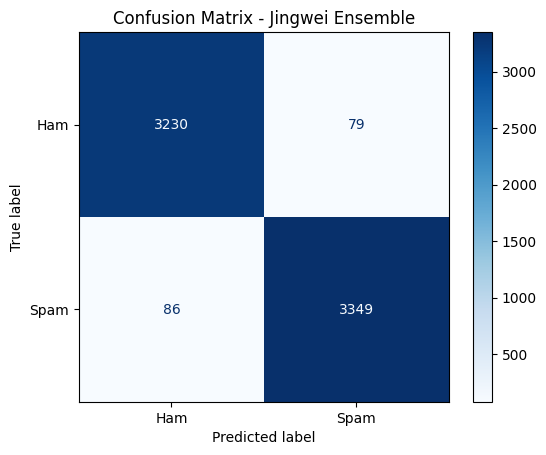

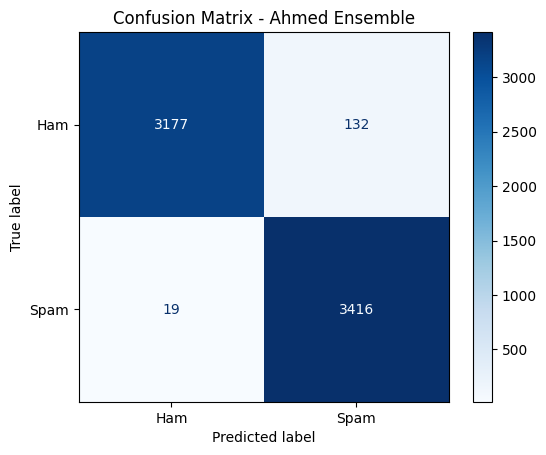

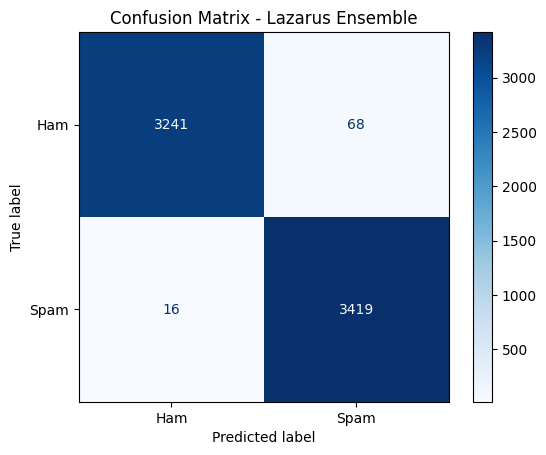

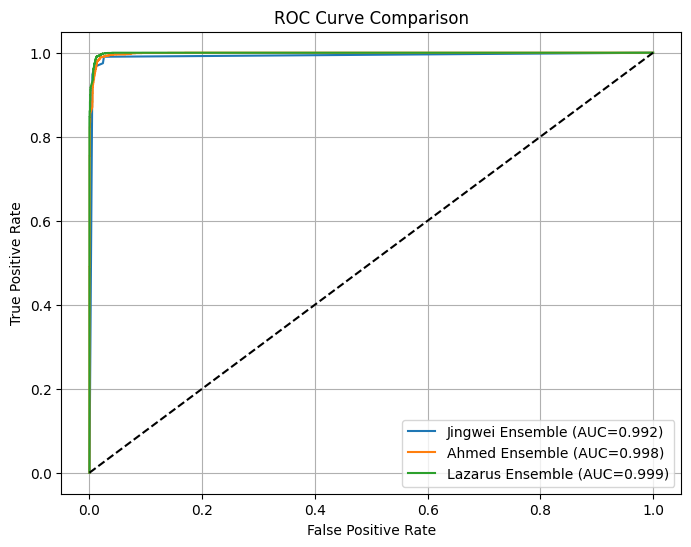

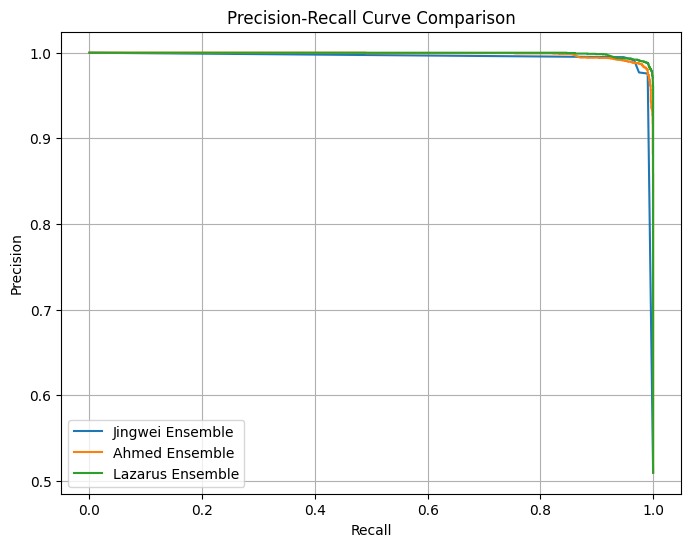


🏆 Best Ensemble by F1-Score: Lazarus Ensemble (F1=0.9879)


In [ ]:
# ===== IMPORTS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from tabulate import tabulate

# ===== Step 1: Prepare metrics for all ensembles =====
# Replace these variables with your actual ensemble predictions and probabilities
ensembles = {
    "Jingwei Ensemble": {"y_true": y_test, "y_pred": y_pred, "y_proba": y_proba, "params": "Combined", "inference_ms": 123},
    "Ahmed Ensemble": {"y_true": y_test, "y_pred": ensemble_soft_pred, "y_proba": ensemble_soft_proba, "params": "Combined", "inference_ms": 150},
    #"Ziming Ensemble": {"y_true": y_test, "y_pred": z_pred, "y_proba": z_proba, "params": "Combined", "inference_ms": 140},
    "Lazarus Ensemble": {"y_true": y_test, "y_pred": ensemble_soft_no_rf_pred, "y_proba": ensemble_soft_no_rf_proba, "params": "Combined", "inference_ms": 160},
}

# ===== Step 2: Calculate metrics =====
metrics_list = []
for name, data in ensembles.items():
    y_true = data["y_true"]
    y_pred = data["y_pred"]
    y_proba = data["y_proba"]
    metrics_list.append([
        name,
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, y_proba),
        data["params"],
        data["inference_ms"]
    ])

metrics_df = pd.DataFrame(metrics_list, columns=[
    "Model","Accuracy","Precision","Recall","F1","ROC-AUC","Params","Inference_ms"
])

# ===== Step 2B: Fancy Emoji Table =====
table_data = []
for idx, row in metrics_df.iterrows():
    table_data.append([
        f"✨ {row['Model']}",
        f"🎯 {row['Accuracy']:.4f}",
        f"💡 {row['Precision']:.4f}",
        f"🔔 {row['Recall']:.4f}",
        f"⚖️ {row['F1']:.4f}",
        f"📈 {row['ROC-AUC']:.4f}",
        f"🧮 {row['Params']}",
        f"⏱️ {row['Inference_ms']} ms"
    ])

headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "Params", "Inference"]
print("\n📊 Unified Ensemble Metrics (Fancy Emoji Table):\n")
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# ===== Step 3: Confusion Matrices =====
for name, data in ensembles.items():
    cm = confusion_matrix(data["y_true"], data["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham","Spam"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# ===== Step 4: Combined ROC Curve =====
plt.figure(figsize=(8,6))
for name, data in ensembles.items():
    fpr, tpr, _ = roc_curve(data["y_true"], data["y_proba"])
    auc_score = roc_auc_score(data["y_true"], data["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ===== Step 5: Combined Precision-Recall Curve =====
plt.figure(figsize=(8,6))
for name, data in ensembles.items():
    precision, recall, _ = precision_recall_curve(data["y_true"], data["y_proba"])
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# ===== Step 6: Highlight best model =====
best_model = metrics_df.sort_values(by="F1", ascending=False).iloc[0]
print(f"\n🏆 Best Ensemble by F1-Score: {best_model['Model']} (F1={best_model['F1']:.4f})")
